In [1]:
from bayes3d.dino import Dino
import bayes3d as b
import os
import torch
import numpy as np
import matplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as T
import bayes3d.ycb_loader
import bayes3d.o3d_viz
from tqdm import tqdm
import open3d as o3d


/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dino = dinov2_vitg14.to(device)  # Same issue with larger model
feat_dim = 1536 # vitg14


def get_embeddings(rgbd):
    img = b.get_rgb_image(rgbd.rgb).convert('RGB')
    patch_h, patch_w = np.array(img.size) // 14
    transform = T.Compose([
        T.GaussianBlur(9, sigma=(0.1, 2.0)),
        T.Resize((patch_h * 14, patch_w * 14)),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    tensor = transform(img)[:3].unsqueeze(0).to(device)
    with torch.no_grad():
        features_dict = dinov2_vitg14.forward_features(tensor)
        features = features_dict['x_norm_patchtokens'][0].reshape((patch_h, patch_w, feat_dim)).permute(2, 0, 1).unsqueeze(0)
    print(features.shape)
    img_feat_norm = torch.nn.functional.normalize(features, dim=1)
    output = jnp.array(img_feat_norm.cpu().detach().numpy())[0]
    del img_feat_norm
    del features
    del tensor
    del features_dict
    torch.cuda.empty_cache()
    return jnp.transpose(output, (1,2,0))

Using cache found in /home/nishadgothoskar/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
h = 1400
intrinsics = b.Intrinsics(
    height=h,
    width=h,
    fx=3300.0, fy=3300.0,
    cx=h/2.0, cy=h/2.0,
    near=0.001, far=6.0
)
scaled_down_intrinsics = b.camera.scale_camera_parameters(intrinsics, 1.0/14.0)


In [5]:
b.setup_renderer(scaled_down_intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [6]:
viz = b.o3d_viz.O3DVis(intrinsics)

[Open3D INFO] EGL headless mode enabled.


In [7]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_paths = []
for idx in range(1,22):
    mesh_paths.append(os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply"))
SCALING_FACTOR = 1.0/1000.0
mesh_filename = mesh_paths[2]


In [8]:

# training_images = []
# training_angles = jnp.linspace(-jnp.pi, jnp.pi, 101)[:-1]
# for angle in tqdm(angles):
#     mesh = o3d.io.read_triangle_model(mesh_filename)
#     pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
#         jnp.array([0.0, 0.6, 0.0]),
#         jnp.array([0.0, 0.0, 0.0]),
#         jnp.array([0.0, 0.0, 1.0]),
#     )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)

#     viz.clear()

#     mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
#     mesh.meshes[0].mesh.transform(pose)
#     viz.render.scene.add_model(f"1", mesh)

#     training_images.append(viz.capture_image(intrinsics, jnp.eye(4)))
# jnp.savez("data.npz",training_images=training_images, training_angles=training_angles)

In [9]:
data = jnp.load("data.npz", allow_pickle=True)
training_images = data["training_images"]
training_angles = data["angles"]

In [26]:
jnp.max(jnp.array([2000,200]))

Array(2000, dtype=int32)

In [27]:
num_images = len(training_images)
training_indices = jnp.arange(0,num_images, num_images//4)

keypoint_coordinates = []
keypoint_embeddings = []

for idx in tqdm(training_indices):
    angle = training_angles[idx]
    training_image = training_images[idx]
    pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)

    scaled_down_training_image = b.scale_rgbd(training_image, 1.0/14.0)
    embeddings = get_embeddings(training_image)
    foreground_mask = (jnp.inf != scaled_down_training_image.depth)
    foreground_pixel_coordinates = jnp.transpose(jnp.vstack(jnp.where(foreground_mask)))

    NUM_KEYPOINTS_TO_SELECT = jnp.min(jnp.array([2000,foreground_pixel_coordinates.shape[0]]))
    subset = jax.random.choice(jax.random.PRNGKey(10),foreground_pixel_coordinates.shape[0], shape=(NUM_KEYPOINTS_TO_SELECT,), replace=False)

    depth = jnp.array(scaled_down_training_image.depth)
    depth = depth.at[depth == jnp.inf].set(0.0)
    point_cloud_image = b.t3d.unproject_depth(depth, scaled_down_training_image.intrinsics)

    keypoint_world_coordinates = point_cloud_image[foreground_pixel_coordinates[subset,0], foreground_pixel_coordinates[subset,1],:]
    _keypoint_coordinates = b.t3d.apply_transform(keypoint_world_coordinates, b.t3d.inverse_pose(pose))
    _keypoint_embeddings = embeddings[foreground_pixel_coordinates[subset,0], foreground_pixel_coordinates[subset,1],:]
    
    keypoint_coordinates.append(_keypoint_coordinates)
    keypoint_embeddings.append(_keypoint_embeddings)
    
    

  0%|                                                                                                                                           | 0/4 [00:00<?, ?it/s]/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.stor

torch.Size([1, 1536, 100, 100])


 25%|████████████████████████████████▊                                                                                                  | 1/4 [00:03<00:10,  3.55s/it]

torch.Size([1, 1536, 100, 100])


 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2/4 [00:07<00:07,  3.53s/it]

torch.Size([1, 1536, 100, 100])


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3/4 [00:10<00:03,  3.41s/it]

torch.Size([1, 1536, 100, 100])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.30s/it]


In [28]:
keypoint_coordinates = jnp.concatenate(keypoint_coordinates)
keypoint_embeddings = jnp.concatenate(keypoint_embeddings)
print(keypoint_coordinates.shape)
print(keypoint_embeddings.shape)

(6500, 3)
(6500, 1536)


In [29]:
b.setup_renderer(scaled_down_training_image.intrinsics)
b.RENDERER.add_mesh_from_file(mesh_filename, scaling_factor=SCALING_FACTOR)
b.setup_renderer(scaled_down_training_image.intrinsics)
b.RENDERER.add_mesh_from_file(mesh_filename, scaling_factor=SCALING_FACTOR)

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6
[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [30]:
def render_embedding_image(pose, keypoint_coordinates, keypoint_embeddings):
    point_cloud_img = b.RENDERER.render_single_object(pose, jnp.int32(0))[:,:,:3]
    point_cloud_img_in_object_frame = b.t3d.apply_transform(point_cloud_img, b.t3d.inverse_pose(pose))

    distances_to_keypoints = (
        jnp.linalg.norm(point_cloud_img_in_object_frame[:, :,None,...] - keypoint_coordinates[None, None,:,...],
        axis=-1
    ))
    index_of_nearest_keypoint = distances_to_keypoints.argmin(2)
    distance_to_nearest_keypoints = distances_to_keypoints[jnp.arange(distances_to_keypoints.shape[0]), jnp.arange(distances_to_keypoints.shape[1]), 
                       index_of_nearest_keypoint]
    DISTANCE_THRESHOLD = 0.05
    valid_match_mask = (distance_to_nearest_keypoints < DISTANCE_THRESHOLD)[...,None]
        
    rendered_embeddings_image = keypoint_embeddings[index_of_nearest_keypoint] * valid_match_mask
    return rendered_embeddings_image

def score_pose(pose, keypoint_coordinates, keypoint_embeddings, observed_embeddings):
    rendrendered_embeddings_image = render_embedding_image(pose, keypoint_coordinates, keypoint_embeddings)
    dot_products = jnp.einsum("abi,abi->ab", rendrendered_embeddings_image, observed_embeddings)
    return dot_products.mean()

score_pose_jit = jax.jit(score_pose)

In [41]:

angles = jnp.linspace(-jnp.pi, jnp.pi, 300)
scorer = lambda angle, observed_embeddings: score_pose(
    b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle),
    keypoint_coordinates, keypoint_embeddings, observed_embeddings
)
scorer_jit = jax.jit(scorer)
scorer_parallel_jit = jax.jit(jax.vmap(scorer, in_axes=(0,None)))


In [43]:
IDX = 10
test_rgbd = training_images[IDX]
observed_embeddings = get_embeddings(test_rgbd)
training_angles[IDX]

torch.Size([1, 1536, 100, 100])


-2.5132742

In [44]:
all_posteriors = []
for IDX in tqdm(range(len(training_images))):
    test_rgbd = training_images[IDX]
    observed_embeddings = get_embeddings(test_rgbd)
    posterior = jnp.concatenate([scorer_parallel_jit(i, observed_embeddings) for i in jnp.array_split(angles, 10)])
    all_posteriors.append(posterior)

  0%|                                                                                                                                         | 0/100 [00:00<?, ?it/s]

torch.Size([1, 1536, 100, 100])


  1%|█▎                                                                                                                               | 1/100 [00:03<06:16,  3.80s/it]

torch.Size([1, 1536, 100, 100])


  2%|██▌                                                                                                                              | 2/100 [00:06<05:10,  3.17s/it]

torch.Size([1, 1536, 100, 100])


  3%|███▊                                                                                                                             | 3/100 [00:09<04:51,  3.01s/it]

torch.Size([1, 1536, 100, 100])


  4%|█████▏                                                                                                                           | 4/100 [00:12<04:41,  2.93s/it]

torch.Size([1, 1536, 100, 100])


  5%|██████▍                                                                                                                          | 5/100 [00:14<04:34,  2.89s/it]

torch.Size([1, 1536, 100, 100])


  6%|███████▋                                                                                                                         | 6/100 [00:17<04:26,  2.83s/it]

torch.Size([1, 1536, 100, 100])


  7%|█████████                                                                                                                        | 7/100 [00:20<04:19,  2.80s/it]

torch.Size([1, 1536, 100, 100])


  8%|██████████▎                                                                                                                      | 8/100 [00:23<04:14,  2.77s/it]

torch.Size([1, 1536, 100, 100])


  9%|███████████▌                                                                                                                     | 9/100 [00:25<04:10,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 10%|████████████▊                                                                                                                   | 10/100 [00:28<04:07,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 11%|██████████████                                                                                                                  | 11/100 [00:31<04:03,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 12%|███████████████▎                                                                                                                | 12/100 [00:34<04:00,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 13%|████████████████▋                                                                                                               | 13/100 [00:36<03:57,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 14%|█████████████████▉                                                                                                              | 14/100 [00:39<03:54,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 15%|███████████████████▏                                                                                                            | 15/100 [00:42<03:52,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 16%|████████████████████▍                                                                                                           | 16/100 [00:44<03:49,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 17%|█████████████████████▊                                                                                                          | 17/100 [00:47<03:46,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 18%|███████████████████████                                                                                                         | 18/100 [00:50<03:43,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 19%|████████████████████████▎                                                                                                       | 19/100 [00:53<03:41,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 20%|█████████████████████████▌                                                                                                      | 20/100 [00:55<03:40,  2.76s/it]

torch.Size([1, 1536, 100, 100])


 21%|██████████████████████████▉                                                                                                     | 21/100 [00:58<03:37,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 22%|████████████████████████████▏                                                                                                   | 22/100 [01:01<03:34,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 23%|█████████████████████████████▍                                                                                                  | 23/100 [01:04<03:31,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 24%|██████████████████████████████▋                                                                                                 | 24/100 [01:06<03:28,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 25%|████████████████████████████████                                                                                                | 25/100 [01:09<03:25,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 26%|█████████████████████████████████▎                                                                                              | 26/100 [01:12<03:24,  2.77s/it]

torch.Size([1, 1536, 100, 100])


 27%|██████████████████████████████████▌                                                                                             | 27/100 [01:15<03:21,  2.76s/it]

torch.Size([1, 1536, 100, 100])


 28%|███████████████████████████████████▊                                                                                            | 28/100 [01:17<03:17,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 29%|█████████████████████████████████████                                                                                           | 29/100 [01:20<03:14,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 30%|██████████████████████████████████████▍                                                                                         | 30/100 [01:23<03:11,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 31%|███████████████████████████████████████▋                                                                                        | 31/100 [01:26<03:08,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 32%|████████████████████████████████████████▉                                                                                       | 32/100 [01:28<03:06,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 33%|██████████████████████████████████████████▏                                                                                     | 33/100 [01:31<03:03,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 34%|███████████████████████████████████████████▌                                                                                    | 34/100 [01:34<03:00,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 35%|████████████████████████████████████████████▊                                                                                   | 35/100 [01:37<02:57,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 36%|██████████████████████████████████████████████                                                                                  | 36/100 [01:39<02:54,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 37%|███████████████████████████████████████████████▎                                                                                | 37/100 [01:42<02:52,  2.73s/it]

torch.Size([1, 1536, 100, 100])


 38%|████████████████████████████████████████████████▋                                                                               | 38/100 [01:45<02:53,  2.79s/it]

torch.Size([1, 1536, 100, 100])


 39%|█████████████████████████████████████████████████▉                                                                              | 39/100 [01:48<02:52,  2.83s/it]

torch.Size([1, 1536, 100, 100])


 40%|███████████████████████████████████████████████████▏                                                                            | 40/100 [01:51<02:47,  2.80s/it]

torch.Size([1, 1536, 100, 100])


 41%|████████████████████████████████████████████████████▍                                                                           | 41/100 [01:54<02:48,  2.86s/it]

torch.Size([1, 1536, 100, 100])


 42%|█████████████████████████████████████████████████████▊                                                                          | 42/100 [01:56<02:43,  2.82s/it]

torch.Size([1, 1536, 100, 100])


 43%|███████████████████████████████████████████████████████                                                                         | 43/100 [01:59<02:39,  2.80s/it]

torch.Size([1, 1536, 100, 100])


 44%|████████████████████████████████████████████████████████▎                                                                       | 44/100 [02:02<02:35,  2.78s/it]

torch.Size([1, 1536, 100, 100])


 45%|█████████████████████████████████████████████████████████▌                                                                      | 45/100 [02:05<02:34,  2.82s/it]

torch.Size([1, 1536, 100, 100])


 46%|██████████████████████████████████████████████████████████▉                                                                     | 46/100 [02:07<02:30,  2.79s/it]

torch.Size([1, 1536, 100, 100])


 47%|████████████████████████████████████████████████████████████▏                                                                   | 47/100 [02:10<02:30,  2.83s/it]

torch.Size([1, 1536, 100, 100])


 48%|█████████████████████████████████████████████████████████████▍                                                                  | 48/100 [02:13<02:25,  2.80s/it]

torch.Size([1, 1536, 100, 100])


 49%|██████████████████████████████████████████████████████████████▋                                                                 | 49/100 [02:16<02:23,  2.81s/it]

torch.Size([1, 1536, 100, 100])


 50%|████████████████████████████████████████████████████████████████                                                                | 50/100 [02:19<02:19,  2.79s/it]

torch.Size([1, 1536, 100, 100])


 51%|█████████████████████████████████████████████████████████████████▎                                                              | 51/100 [02:21<02:15,  2.77s/it]

torch.Size([1, 1536, 100, 100])


 52%|██████████████████████████████████████████████████████████████████▌                                                             | 52/100 [02:24<02:12,  2.76s/it]

torch.Size([1, 1536, 100, 100])


 53%|███████████████████████████████████████████████████████████████████▊                                                            | 53/100 [02:27<02:09,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 54%|█████████████████████████████████████████████████████████████████████                                                           | 54/100 [02:30<02:06,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 55%|██████████████████████████████████████████████████████████████████████▍                                                         | 55/100 [02:32<02:03,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 56%|███████████████████████████████████████████████████████████████████████▋                                                        | 56/100 [02:35<02:00,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 57/100 [02:38<01:57,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 58/100 [02:41<01:55,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 59/100 [02:43<01:54,  2.79s/it]

torch.Size([1, 1536, 100, 100])


 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 60/100 [02:46<01:51,  2.78s/it]

torch.Size([1, 1536, 100, 100])


 61%|██████████████████████████████████████████████████████████████████████████████                                                  | 61/100 [02:49<01:47,  2.77s/it]

torch.Size([1, 1536, 100, 100])


 62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 62/100 [02:52<01:44,  2.76s/it]

torch.Size([1, 1536, 100, 100])


 63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 63/100 [02:54<01:41,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 64/100 [02:57<01:38,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 65/100 [03:00<01:36,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 66/100 [03:03<01:33,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 67/100 [03:06<01:32,  2.79s/it]

torch.Size([1, 1536, 100, 100])


 68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 68/100 [03:08<01:28,  2.78s/it]

torch.Size([1, 1536, 100, 100])


 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 69/100 [03:11<01:25,  2.76s/it]

torch.Size([1, 1536, 100, 100])


 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 70/100 [03:14<01:24,  2.81s/it]

torch.Size([1, 1536, 100, 100])


 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 71/100 [03:17<01:21,  2.82s/it]

torch.Size([1, 1536, 100, 100])


 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 72/100 [03:19<01:18,  2.79s/it]

torch.Size([1, 1536, 100, 100])


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 73/100 [03:22<01:14,  2.77s/it]

torch.Size([1, 1536, 100, 100])


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 74/100 [03:25<01:11,  2.76s/it]

torch.Size([1, 1536, 100, 100])


 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 75/100 [03:28<01:08,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 76/100 [03:30<01:05,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 77/100 [03:33<01:03,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 78/100 [03:36<01:00,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 79/100 [03:39<00:57,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 80/100 [03:41<00:54,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 81/100 [03:44<00:51,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 82/100 [03:47<00:49,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 83/100 [03:50<00:46,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 84/100 [03:52<00:43,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 85/100 [03:55<00:41,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 86/100 [03:58<00:39,  2.79s/it]

torch.Size([1, 1536, 100, 100])


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 87/100 [04:01<00:36,  2.81s/it]

torch.Size([1, 1536, 100, 100])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 88/100 [04:04<00:33,  2.78s/it]

torch.Size([1, 1536, 100, 100])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 89/100 [04:06<00:30,  2.77s/it]

torch.Size([1, 1536, 100, 100])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 90/100 [04:09<00:27,  2.76s/it]

torch.Size([1, 1536, 100, 100])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 91/100 [04:12<00:24,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [04:14<00:21,  2.75s/it]

torch.Size([1, 1536, 100, 100])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [04:17<00:19,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 94/100 [04:20<00:16,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 95/100 [04:23<00:13,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [04:25<00:10,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [04:28<00:08,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [04:31<00:05,  2.74s/it]

torch.Size([1, 1536, 100, 100])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [04:34<00:02,  2.73s/it]

torch.Size([1, 1536, 100, 100])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:36<00:00,  2.77s/it]


In [46]:
all_posteriors = jnp.array(all_posteriors)

In [66]:
errors = jnp.abs(angles[all_posteriors.argmax(1)] - training_angles)
degree_errors = jnp.rad2deg(errors)
jnp.mean(degree_errors),jnp.std(degree_errors)

(Array(0.8153592, dtype=float32), Array(0.78376585, dtype=float32))

In [ ]:
jnp.

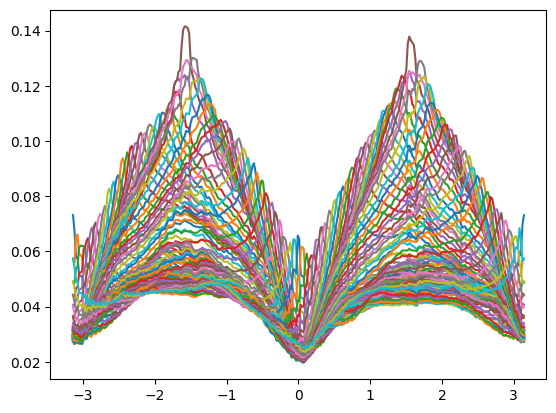

In [45]:
plt.clf()
for posteriors in all_posteriors:
    plt.plot(angles, posteriors)


In [19]:
angles[IDX]

Array(-3.0575368, dtype=float32)

In [21]:
print(angles[jnp.argmax(jnp.array(scores))])

1.9858227


In [34]:
jnp.pi/2

1.5707963267948966

/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


torch.Size([1, 1536, 100, 100])


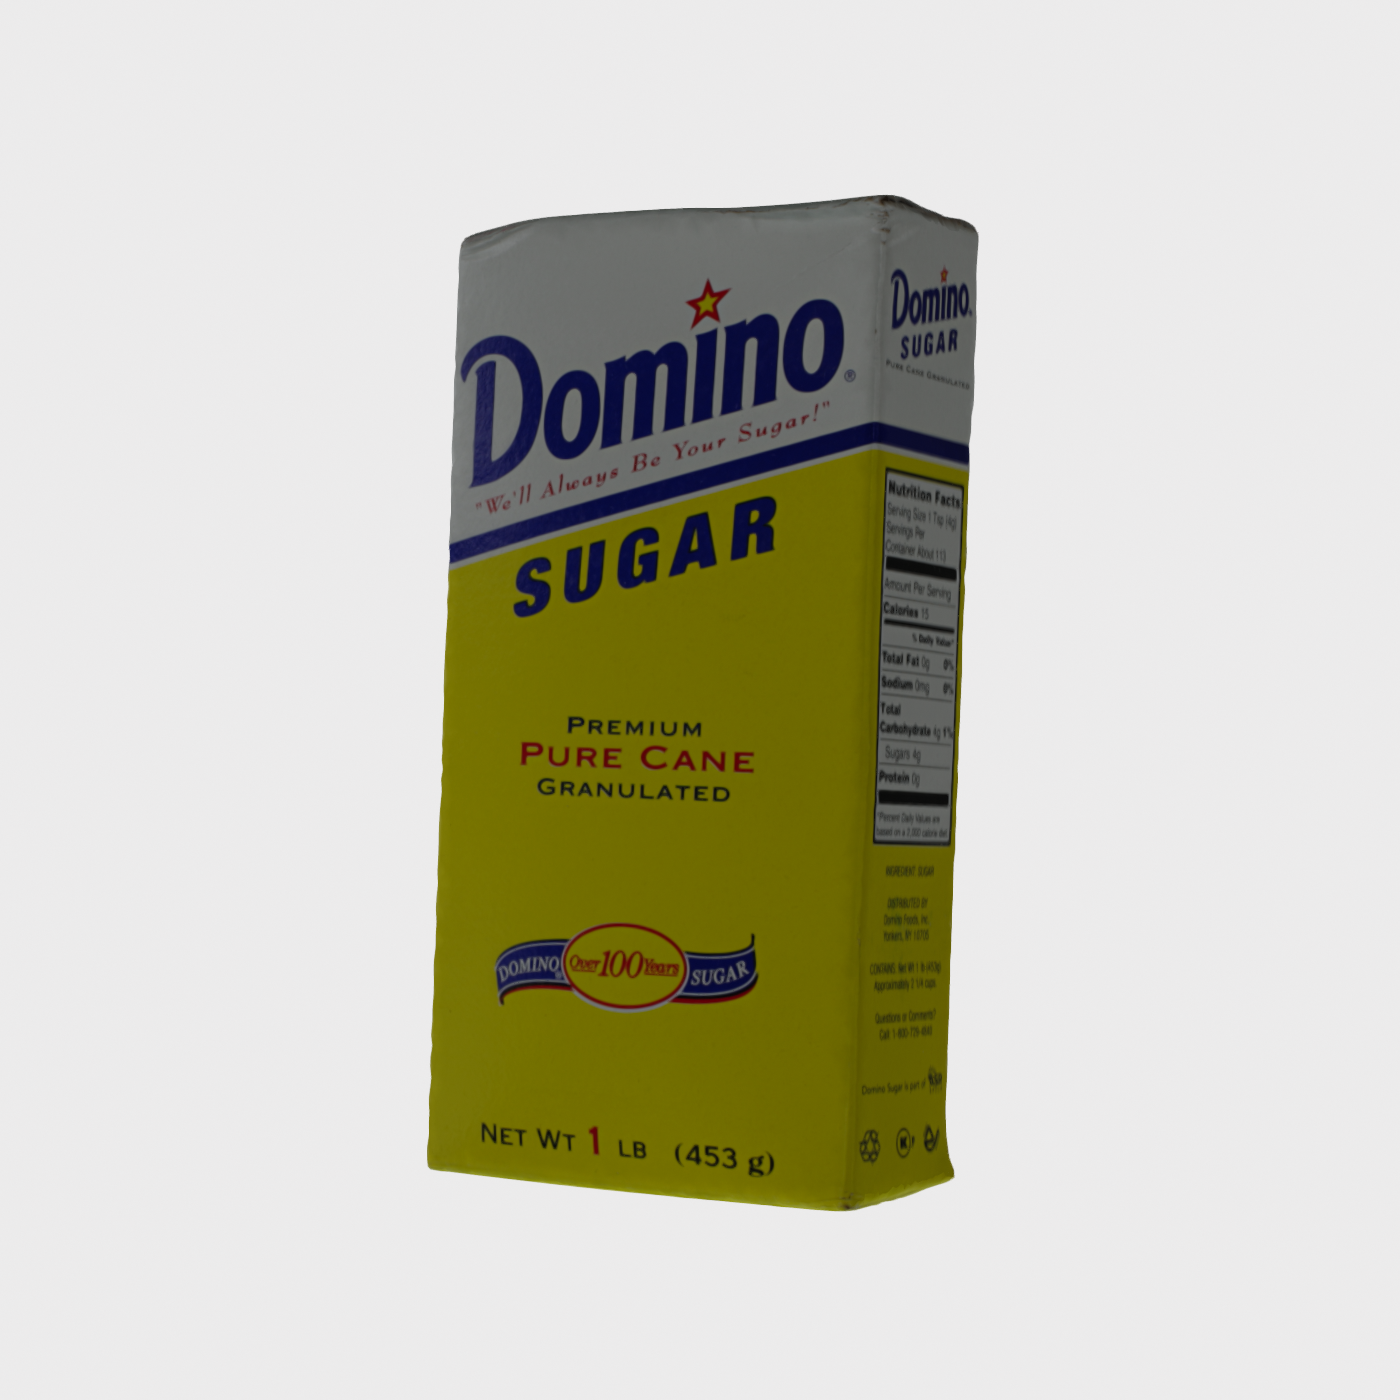

In [35]:
mesh_filename = mesh_paths[2]
angle = jnp.pi/2 - 0.5
mesh = o3d.io.read_triangle_model(mesh_filename)
pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 0.6, 0.0]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)

viz.clear()

mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
mesh.meshes[0].mesh.transform(pose)
viz.render.scene.add_model(f"1", mesh)

training_rgbd = viz.capture_image(intrinsics, jnp.eye(4))
scaled_down_training_image = b.scale_rgbd(training_rgbd, 1.0/14.0) 

observed_embeddings = get_embeddings(training_rgbd)
b.get_rgb_image(training_rgbd.rgb)

In [37]:
observed_embeddings.shape

(100, 100, 1536)

In [38]:
angles = jnp.linspace(-jnp.pi, jnp.pi, 300)
scores = []
for angle in tqdm(angles):
    pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)
    scores.append(score_pose_jit(pose, keypoint_coordinates, keypoint_embeddings, observed_embeddings))
import matplotlib.pyplot as plt
plt.plot(angles, scores)

2023-05-24 18:38:17.971524: E external/xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:790] failed to record completion event; therefore, failed to create inter-stream dependency
2023-05-24 18:38:17.971656: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1182] failed to enqueue async memcpy from host to device: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered; GPU dst: 0x7fc3bbc00000; host src: 0x7fc3bbe00000; size: 4=0x4
2023-05-24 18:38:17.971690: E external/xla/xla/stream_executor/stream.cc:336] Error recording event in stream: Error recording CUDA event: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered; not marking stream as bad, as the Event object may be at fault. Monitor for further errors.
2023-05-24 18:38:17.971715: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:617] unable to add host callback: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2023-05-24 18:38:17.971911: E external/xla/xla/stream_exec

ValueError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.func.launch' failed: Failed to launch CUDA kernel: fusion with block dimensions: 300x1x1 and grid dimensions: 1x1x1: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered.